In [1]:
import os
import itertools
import numpy as np
import pandas as pd
import requests as rq
from tqdm.auto import tqdm
from collections import Counter


from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio import AlignIO, SeqIO
from Bio.Align.Applications import ClustalwCommandline

from biotite.sequence import ProteinSequence
from biotite.sequence.align import SubstitutionMatrix, align_multiple
from biotite.sequence import LetterAlphabet
from biotite.sequence.graphics import plot_alignment_type_based

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

plt.style.use('seaborn-poster')

In [2]:
uniprot = pd.read_csv('seqs/csv/uniprot-filtered-reviewed_yes.tab', sep='\t', index_col=0).drop_duplicates('Sequence')
uniprot = uniprot[~uniprot['Domain [FT]'].isna()].copy()
uniprot = uniprot[uniprot['Domain [FT]'].str.lower().str.contains('upar')].copy()
uniprot

,Entry name,Protein names,Gene names,Organism,Length,Domain [FT],Sequence
Entry,,,,,,,
P0DP61,SLUR2_MACMU,Secreted Ly-6/uPAR domain-containing protein 2,SLURP2,Macaca mulatta (Rhesus macaque),97,"DOMAIN 23..95; /note=""UPAR/Ly6""",MQFHTGLLLAAVLSLQLAAAQALWCHQCTGFGGCSRGSRCPRDSTH...
P55000,SLUR1_HUMAN,Secreted Ly-6/uPAR-related protein 1 (SLURP-1)...,SLURP1 ARS,Homo sapiens (Human),103,"DOMAIN 24..73; /note=""UPAR/Ly6""",MASRWAVQLLLVAAWSMGCGEALKCYTCKEPMTSASCRTITRCKPE...
P83107,SOLD1_BOVIN,Secreted protein of Ly-6 domain 1 (Protein BOP1),SOLD1 BOP1,Bos taurus (Bovine),100,"DOMAIN 23..100; /note=""UPAR/Ly6""; /evidence=...",MAKCLLLLLLVVLSSLLGLPQALECFQCNRVNASGVCETGGSTCQT...
P0DP57,SLUR2_HUMAN,Secreted Ly-6/uPAR domain-containing protein 2...,SLURP2,Homo sapiens (Human),97,"DOMAIN 25..95; /note=""UPAR/Ly6""; /evidence=""...",MQLGTGLLLAAVLSLQLAAAEAIWCHQCTGFGGCSHGSRCLRDSTH...
D3YWX3,PAT13_MOUSE,Prostate and testis expressed protein 13 (Pros...,Pate13 Gm3867 Pate-X,Mus musculus (Mouse),137,"DOMAIN 28..114; /note=""UPAR/Ly6""; /evidence=...",MFQKLLLSVFIILLMDVGERVLTFNLLRHCNLCSHYDGFKCRNGMK...
...,...,...,...,...,...,...,...
Q9GK80,UPAR_PANTR,Urokinase plasminogen activator surface recept...,PLAUR UPAR,Pan troglodytes (Chimpanzee),335,"DOMAIN 23..114; /note=""UPAR/Ly6 1""; DOMAIN 11...",MGHPPLLPLLLLLHTCVPASWGLRCMQCKTNGDCRVEECALGQDLC...
P35456,UPAR_MOUSE,Urokinase plasminogen activator surface recept...,Plaur,Mus musculus (Mouse),327,"DOMAIN 24..117; /note=""UPAR/Ly6 1""; DOMAIN 11...",MGLPRRLLLLLLLATTCVPASQGLQCMQCESNQSCLVEECALGQDL...
P57096,PSCA_MOUSE,Prostate stem cell antigen,Psca,Mus musculus (Mouse),123,"DOMAIN 21..95; /note=""UPAR/Ly6""",MKTVFFLLLATYLALHPGAALQCYSCTAQMNNRDCLNVQNCSLDQH...


In [3]:
known_upars = set(pd.read_csv('seqs/csv/acess_upar.txt', squeeze=True)) | set(uniprot.index)
len(known_upars)

198

In [4]:
def retrieve_uniprot_data_by_acess(acess):
    """
    Retrieve protein by ID from UniProt
    """
    requestURL = f"https://www.ebi.ac.uk/proteins/api/proteins/{acess}"
#     print(requestURL)
    r = rq.get(requestURL, headers={"Accept" : "application/json"})

    if not r.ok:
        r.raise_for_status()
        return 0
    responseBody = r.json()

    try:
        features = responseBody['features']
    except KeyError:
        type_ = None
        start, end = np.nan, np.nan
    else:
        st_nd = [(start := i['begin'], end := i['end']) for i in features if i.get('description') and i['description'] == 'UPAR/Ly6']
        type_ = 'DOMAIN'
        if not st_nd:
            type_ = 'CHAIN'
            st_nd = [(start := i['begin'], end := i['end']) for i in features if i['type'] == 'CHAIN'] 

    try:
        prot_name = responseBody['protein']['submittedName'][0]['fullName']['value']

    except:
        prot_name = responseBody['protein']['recommendedName']['fullName']['value']
    
    return {'sequence': responseBody['sequence']['sequence'],
            'id': responseBody['id'],
            'protein_name': prot_name,
            'org': responseBody['organism']['names'][0]['value'],
            'start': start,
            'end': end,
            'type_': type_,
            'acess': acess}

In [5]:
res = pd.DataFrame()
for acess in tqdm(known_upars):
    tmp = retrieve_uniprot_data_by_acess(acess)
    if tmp:
        res = res.append(tmp, ignore_index=True)
    else:
        print('!!!!!!!!!!!!!!!')
        break
res = res.drop_duplicates('sequence')

short = res[res.sequence.str.len() < 190].copy()
short = short.fillna(-1)
short.start, short.end = short.start.astype(np.int32), short.end.astype(np.int32)

long = res[res.sequence.str.len() > 190].copy()

  0%|          | 0/198 [00:00<?, ?it/s]

In [6]:
res.shape[0] == res.drop_duplicates('id').shape[0]

True

In [7]:
print(long.shape, short.shape)
res

(44, 8) (153, 8)


,sequence,id,protein_name,org,start,end,type_,acess
0,MTPLLTLFLVVLMGLPLAPVQALDCHVCAYNGDNCFNPMRCPAMVA...,LYNX1_MACMU,Ly-6/neurotoxin-like protein 1,Macaca mulatta,23,107,DOMAIN,P0DP62
1,MKTLLLTLVVVTIVCLDLGYTRICFNHQSSQPQTTKTCSPGESSCY...,3S1EB_LATSE,Erabutoxin b,Laticauda semifasciata,22,83,CHAIN,Q90VW1
2,MLPAAMKSLGLALLALLLCPSPAHGLWCQDCTLANSSHCAPKQCQP...,LY6H_MOUSE,Lymphocyte antigen 6H,Mus musculus,26,113,DOMAIN,Q9WUC3
3,RICYIHKASLPRATKTCVENTCYKMFIRTQREYISERGCGCPTAMW...,3SLS_DENPO,Calciseptin,Dendroaspis polylepis polylepis,1,60,CHAIN,P22947
4,RICYTHKSLQAKTTKSCEGNTCYKMFIRTSREYISERGCGCPTAMW...,3SL8_DENJA,Toxin S4C8,Dendroaspis jamesoni kaimosae,1,60,CHAIN,P25683
...,...,...,...,...,...,...,...,...
193,MDSTHATKSCLLILLVALLCAGRAQGLQCYECYGVPIETSCPAVTC...,LY6C2_MOUSE,Lymphocyte antigen 6C2,Mus musculus,27,116,DOMAIN,P0CW03
194,MRFMAGPAGSQSLGPLCFHSSPQALYTVLLIVLVMMSLVFGKFVPV...,LY65C_HUMAN,Lymphocyte antigen 6 complex locus protein G5c,Homo sapiens,60,150,DOMAIN,Q5SRR4
195,MKTLLLTLVVVTIVCLDLGYTMKCKICNFDTCRAGELKVCASGEKY...,3NO4_BUNCA,Candoxin,Bungarus candidus,22,87,CHAIN,P81783
196,MRAQRGLILLLLLLAVFCSTAVSLTCYHCFQPVVSSCNMNSTCSPD...,CD59A_MOUSE,CD59A glycoprotein,Mus musculus,24,96,DOMAIN,O55186


In [8]:
def get_domain(x):
    if hasattr(x, 'start') and x.type_ == 'DOMAIN':
        n_st = x.start - 6
    else:
        n_st = 0
    n_end = len(x.sequence)
    result = []
    for st, en in itertools.product(np.arange(n_st, n_end - 20), np.arange(n_st + 20, n_end + 1)):
        if len((string := x.sequence[st: en])) > 45:
            if 'CN' == string[-2:] and string[2] == 'C' and string.count('C') % 2 == 0 and string.count('C') >= 8 and string.count('C') <= 12 and len(string) < 100:
                result.append(string)
            
    return max(result, key=lambda x: len(x)) if result else np.nan

In [9]:
short['domain'] = short.apply(get_domain, axis=1)
short = short.drop_duplicates('sequence')
inds = short[short.domain.isna()].index
print(inds)
for i in inds:
    short.loc[i, 'domain'] = short.loc[i, 'sequence'][short.loc[i, 'start']: short.loc[i, 'end']]
short

Int64Index([185], dtype='int64')


,sequence,id,protein_name,org,start,end,type_,acess,domain
0,MTPLLTLFLVVLMGLPLAPVQALDCHVCAYNGDNCFNPMRCPAMVA...,LYNX1_MACMU,Ly-6/neurotoxin-like protein 1,Macaca mulatta,23,107,DOMAIN,P0DP62,LDCHVCAYNGDNCFNPMRCPAMVAYCMTTRTYYTPTRMKVSKSCVP...
1,MKTLLLTLVVVTIVCLDLGYTRICFNHQSSQPQTTKTCSPGESSCY...,3S1EB_LATSE,Erabutoxin b,Laticauda semifasciata,22,83,CHAIN,Q90VW1,RICFNHQSSQPQTTKTCSPGESSCYHKQWSDFRGTIIERGCGCPTV...
2,MLPAAMKSLGLALLALLLCPSPAHGLWCQDCTLANSSHCAPKQCQP...,LY6H_MOUSE,Lymphocyte antigen 6H,Mus musculus,26,113,DOMAIN,Q9WUC3,LWCQDCTLANSSHCAPKQCQPTDTVCASVRITDPSSSRKDHSVNKM...
3,RICYIHKASLPRATKTCVENTCYKMFIRTQREYISERGCGCPTAMW...,3SLS_DENPO,Calciseptin,Dendroaspis polylepis polylepis,1,60,CHAIN,P22947,RICYIHKASLPRATKTCVENTCYKMFIRTQREYISERGCGCPTAMW...
4,RICYTHKSLQAKTTKSCEGNTCYKMFIRTSREYISERGCGCPTAMW...,3SL8_DENJA,Toxin S4C8,Dendroaspis jamesoni kaimosae,1,60,CHAIN,P25683,RICYTHKSLQAKTTKSCEGNTCYKMFIRTSREYISERGCGCPTAMW...
...,...,...,...,...,...,...,...,...,...
193,MDSTHATKSCLLILLVALLCAGRAQGLQCYECYGVPIETSCPAVTC...,LY6C2_MOUSE,Lymphocyte antigen 6C2,Mus musculus,27,116,DOMAIN,P0CW03,LQCYECYGVPIETSCPAVTCRASDGFCIAQNIELIEDSQRRKLKTR...
194,MRFMAGPAGSQSLGPLCFHSSPQALYTVLLIVLVMMSLVFGKFVPV...,LY65C_HUMAN,Lymphocyte antigen 6 complex locus protein G5c,Homo sapiens,60,150,DOMAIN,Q5SRR4,YRCLLETKELGCLLGSDICLTPAGSSCITLHKKNSSGSDVMVSDCR...
195,MKTLLLTLVVVTIVCLDLGYTMKCKICNFDTCRAGELKVCASGEKY...,3NO4_BUNCA,Candoxin,Bungarus candidus,22,87,CHAIN,P81783,MKCKICNFDTCRAGELKVCASGEKYCFKESWREARGTRIERGCAAT...
196,MRAQRGLILLLLLLAVFCSTAVSLTCYHCFQPVVSSCNMNSTCSPD...,CD59A_MOUSE,CD59A glycoprotein,Mus musculus,24,96,DOMAIN,O55186,LTCYHCFQPVVSSCNMNSTCSPDQDSCLYAVAGMQVYQRCWKQSDC...


In [10]:
lab = pd.read_csv('seqs/csv/Short_len_upar.csv', index_col=0)
lab.Prot = lab.Prot.str.replace(' ', '_').str.upper()
lab = lab.Prot.to_dict()

def rename_for_lab(series: pd.Series):
    lab_name = lab.get(series.acess)
    if lab_name:
        series.id = lab_name + '_' + series.id.split('_')[1]
    return series

In [11]:
short = short.apply(rename_for_lab, axis=1)
short.id = short.id.str.rsplit('_', 1).str[0] + '_|_' + short.org.str.replace(' ', '_')
short.to_csv('seqs/csv/short_upar_all_data.csv', index=None)
short

,sequence,id,protein_name,org,start,end,type_,acess,domain
0,MTPLLTLFLVVLMGLPLAPVQALDCHVCAYNGDNCFNPMRCPAMVA...,LYNX1_|_Macaca_mulatta,Ly-6/neurotoxin-like protein 1,Macaca mulatta,23,107,DOMAIN,P0DP62,LDCHVCAYNGDNCFNPMRCPAMVAYCMTTRTYYTPTRMKVSKSCVP...
1,MKTLLLTLVVVTIVCLDLGYTRICFNHQSSQPQTTKTCSPGESSCY...,ERABUTOXIN_B_|_Laticauda_semifasciata,Erabutoxin b,Laticauda semifasciata,22,83,CHAIN,Q90VW1,RICFNHQSSQPQTTKTCSPGESSCYHKQWSDFRGTIIERGCGCPTV...
2,MLPAAMKSLGLALLALLLCPSPAHGLWCQDCTLANSSHCAPKQCQP...,LY6H_|_Mus_musculus,Lymphocyte antigen 6H,Mus musculus,26,113,DOMAIN,Q9WUC3,LWCQDCTLANSSHCAPKQCQPTDTVCASVRITDPSSSRKDHSVNKM...
3,RICYIHKASLPRATKTCVENTCYKMFIRTQREYISERGCGCPTAMW...,CALCISEPTINE_|_Dendroaspis_polylepis_polylepis,Calciseptin,Dendroaspis polylepis polylepis,1,60,CHAIN,P22947,RICYIHKASLPRATKTCVENTCYKMFIRTQREYISERGCGCPTAMW...
4,RICYTHKSLQAKTTKSCEGNTCYKMFIRTSREYISERGCGCPTAMW...,S4C8_|_Dendroaspis_jamesoni_kaimosae,Toxin S4C8,Dendroaspis jamesoni kaimosae,1,60,CHAIN,P25683,RICYTHKSLQAKTTKSCEGNTCYKMFIRTSREYISERGCGCPTAMW...
...,...,...,...,...,...,...,...,...,...
193,MDSTHATKSCLLILLVALLCAGRAQGLQCYECYGVPIETSCPAVTC...,LY6C2_|_Mus_musculus,Lymphocyte antigen 6C2,Mus musculus,27,116,DOMAIN,P0CW03,LQCYECYGVPIETSCPAVTCRASDGFCIAQNIELIEDSQRRKLKTR...
194,MRFMAGPAGSQSLGPLCFHSSPQALYTVLLIVLVMMSLVFGKFVPV...,LY6G5C_|_Homo_sapiens,Lymphocyte antigen 6 complex locus protein G5c,Homo sapiens,60,150,DOMAIN,Q5SRR4,YRCLLETKELGCLLGSDICLTPAGSSCITLHKKNSSGSDVMVSDCR...
195,MKTLLLTLVVVTIVCLDLGYTMKCKICNFDTCRAGELKVCASGEKY...,CANDOXIN_|_Bungarus_candidus,Candoxin,Bungarus candidus,22,87,CHAIN,P81783,MKCKICNFDTCRAGELKVCASGEKYCFKESWREARGTRIERGCAAT...
196,MRAQRGLILLLLLLAVFCSTAVSLTCYHCFQPVVSSCNMNSTCSPD...,CD59_|_Mus_musculus,CD59A glycoprotein,Mus musculus,24,96,DOMAIN,O55186,LTCYHCFQPVVSSCNMNSTCSPDQDSCLYAVAGMQVYQRCWKQSDC...


In [12]:
short = pd.read_csv('seqs/csv/short_upar_all_data.csv')

In [13]:
def save_df_to_fasta(df, filename, seq_col='sequence', org='org', protein_name='protein_name'):
    req_list = []
    for ind, row in df.iterrows():
        req_list.append(SeqRecord(seq=Seq(row[seq_col]),
                                  id=row.id,
                                  name=row[protein_name],
                                  description='| ' + row[protein_name] + ' | ' + row[org]
                                 ))
    with open(filename, 'w') as f:
        SeqIO.write(req_list, f, 'fasta')

In [14]:
save_df_to_fasta(short, 'blast/blastdb/short_ly_domain_db.fs', seq_col='domain')

In [15]:
%%bash -s 'short_ly_domain_db.fs'
cd 'blast/blastdb/'
makeblastdb -in "$1" -dbtype prot



Building a new DB, current time: 11/26/2021 22:36:05
New DB name:   /home/user503/python/Filogenetics/blast/blastdb/short_ly_domain_db.fs
New DB title:  short_ly_domain_db.fs
Sequence type: Protein
Deleted existing Protein BLAST database named /home/user503/python/Filogenetics/blast/blastdb/short_ly_domain_db.fs
Keep MBits: T
Maximum file size: 1000000000B
Adding sequences from FASTA; added 153 sequences in 0.00616407 seconds.


In [16]:
%%bash -s 'blastdb/short_ly_domain_db.fs' 'aplanci_blast_short.txt' 'arubens_blast_short.txt'
cd 'blast'
blastp -db "$1" -query "../seqs/aplanci_seq.fasta" -outfmt 6 -evalue 1e-5 -num_threads 4 -out "$2"
blastp -db "$1" -query "../seqs/arubens_seq.fasta" -outfmt 6 -evalue 1e-5 -num_threads 4 -out "$3"
ls

aplanci_blast_short.txt
arubens_blast_short.txt
blastdb


In [17]:
def read_blast(name, org):
    df = pd.read_csv(f'seqs/csv/{name}', index_col=0)
    bl_name = name.split('_', 1)[0]
    bl = pd.read_csv(f'blast/{bl_name}_blast_short.txt', index_col=0, sep='\t', header=None).index.unique().tolist()
    df = df.loc[bl].reset_index()
    df['org'] = org
    df['genes'] = df.genes + '_|_' + df.org.str.replace(' ', '_')
    df['domain'] = df.apply(get_domain, axis=1)
    return df.drop_duplicates('domain').set_index('genes')
# [df.sequence.str.len() < 190]

In [18]:
aru = read_blast('arubens_seq.csv', 'Asterias rubens')
apl = read_blast('aplanci_seq.csv', 'Acanthaster planci')
print(aru.shape[0], apl.shape[0])

5 7


In [19]:
aru

,sequence,gene_len,org,domain
genes,,,,
XP_033628517.1_|_Asterias_rubens,MRIKMVFKFRRNSEGIFCILMTLMIILMAVCFRTASSLQCFTCEAE...,155,Asterias rubens,LQCFTCEAEDTNENCNIKEAPVLKTCTSRQDRCLTQVIYSTERGKL...
XP_033635706.1_|_Asterias_rubens,MLMSNQHQCSMYSLRLLLLVVAIMYDATLVMGQTACSVADPVCRCT...,1123,Asterias rubens,AQCYTPESVQRQTIREAPFCIPVQRCYFCDQASTNGACNFATQLCS...
XP_033638913.1_|_Asterias_rubens,MNTLATIVVLMSLIAGMSALTCNTCGWITGVSDESCLDEFDATASN...,126,Asterias rubens,LTCNTCGWITGVSDESCLDEFDATASNSSVTCASGYDMCSKSTTKV...
XP_033640057.1_|_Asterias_rubens,MLLSWPLGIKQWLSPVLFYVVLMSTCSAPTEPTLIFSYDDSTPFPN...,178,Asterias rubens,IKCFTCTDKKSNRECNERAYDAFCPKGTKYCYSSHYLNQKSGESIL...
XP_033644501.1_|_Asterias_rubens,METNPSSQRLVVWMFIFAATIYFAQGNLRCYDCDVDFKTMSNPDLN...,152,Asterias rubens,LRCYDCDVDFKTMSNPDLNCIHNVINSTGDVMYEPRDCQPHERFCK...


In [20]:
apl

,sequence,gene_len,org,domain
genes,,,,
XP_022086630.1_|_Acanthaster_planci,MKMHPINLIFSLVGNVVGLECFDCVDGVSPALDTVACADLFNRTTT...,135,Acanthaster planci,LECFDCVDGVSPALDTVACADLFNRTTTDSRVNRRPCPAGFDACAK...
XP_022094712.1_|_Acanthaster_planci,MWCSMLDLFIASLLICIHTVYSLQCYTCAAEDTNENCKINEAPVLR...,137,Acanthaster planci,LQCYTCAAEDTNENCKINEAPVLRTCPSTEDRCLTQVIYSTERGKL...
XP_022094807.1_|_Acanthaster_planci,MTTIAPTSLLFLVLLLIPRESAAVASQQPLACGDSTGAVAPLCRCT...,1135,Acanthaster planci,QRCYFCDSASTNAACNFAQQQCSGINPACQNEVRVTSGRFLISKSC...
XP_022094806.1_|_Acanthaster_planci,MTTIAPTSLLFLVLLLIPRESAAVASQQPLACGDSTGAVAPLCRCT...,1235,Acanthaster planci,LVCEGGEFSISCGMGGTIDVQWALYGREDGSQACFTPRATPCGDPE...
XP_022100632.1_|_Acanthaster_planci,MKLLLIAGILLASVGSLSAAECYLCSYVPSAMGEECKDPFNSSNNS...,124,Acanthaster planci,AECYLCSYVPSAMGEECKDPFNSSNNSTETCEGTYCLKVVSKISGE...
XP_022109332.1_|_Acanthaster_planci,MHSPSAFLNDVFLQNAVKKHFVMLVCWPKVIQQWLSAAIFCLVFMS...,200,Acanthaster planci,VKCFTCIDKKSNRECNERAYDAFCPKGTKYCYSSHYVNQKTGESIL...
XP_022111363.1_|_Acanthaster_planci,MYLTLFFVNSLFKISNTAKQMDIKLRILMIVILVNNPHNGNAISCY...,344,Acanthaster planci,ISCYVCDTSSNDDCNPGTSTTCGSEQICMNEVREENGLFIVRKMCK...


In [21]:
df = pd.concat([short.set_index('id'), apl]).fillna('').reset_index().rename(columns={'index': 'id'})
save_df_to_fasta(df, 'seqs/blast_apl_short_upar.fasta', seq_col='domain')

In [22]:
df = pd.concat([short.set_index('id'), aru]).fillna('').reset_index().rename(columns={'index': 'id'})
save_df_to_fasta(df, 'seqs/blast_aru_short_upar.fasta', seq_col='domain')

In [23]:
def align(in_, out):
    fasta, align = in_, out

    cmd = ClustalwCommandline('clustalw', infile=fasta, align=True,
                              matrix='matrix.txt', pwmatrix='matrix.txt',
                              type='PROTEIN', outfile=align, quiet=True)
    x = cmd()
    for i in x:
        print(i)
    
    os.rename(fasta.rsplit('.', 1)[0] + '.dnd',
              align.rsplit('.', 1)[0] + '.dnd')

In [24]:
align('seqs/blast_aru_short_upar.fasta', 'result/aln/blast_aru_short_align.aln')




 CLUSTAL 2.1 Multiple Sequence Alignments


Sequence type explicitly set to Protein











In [25]:
align('seqs/blast_apl_short_upar.fasta', 'result/aln/blast_apl_short_align.aln')




 CLUSTAL 2.1 Multiple Sequence Alignments


Sequence type explicitly set to Protein











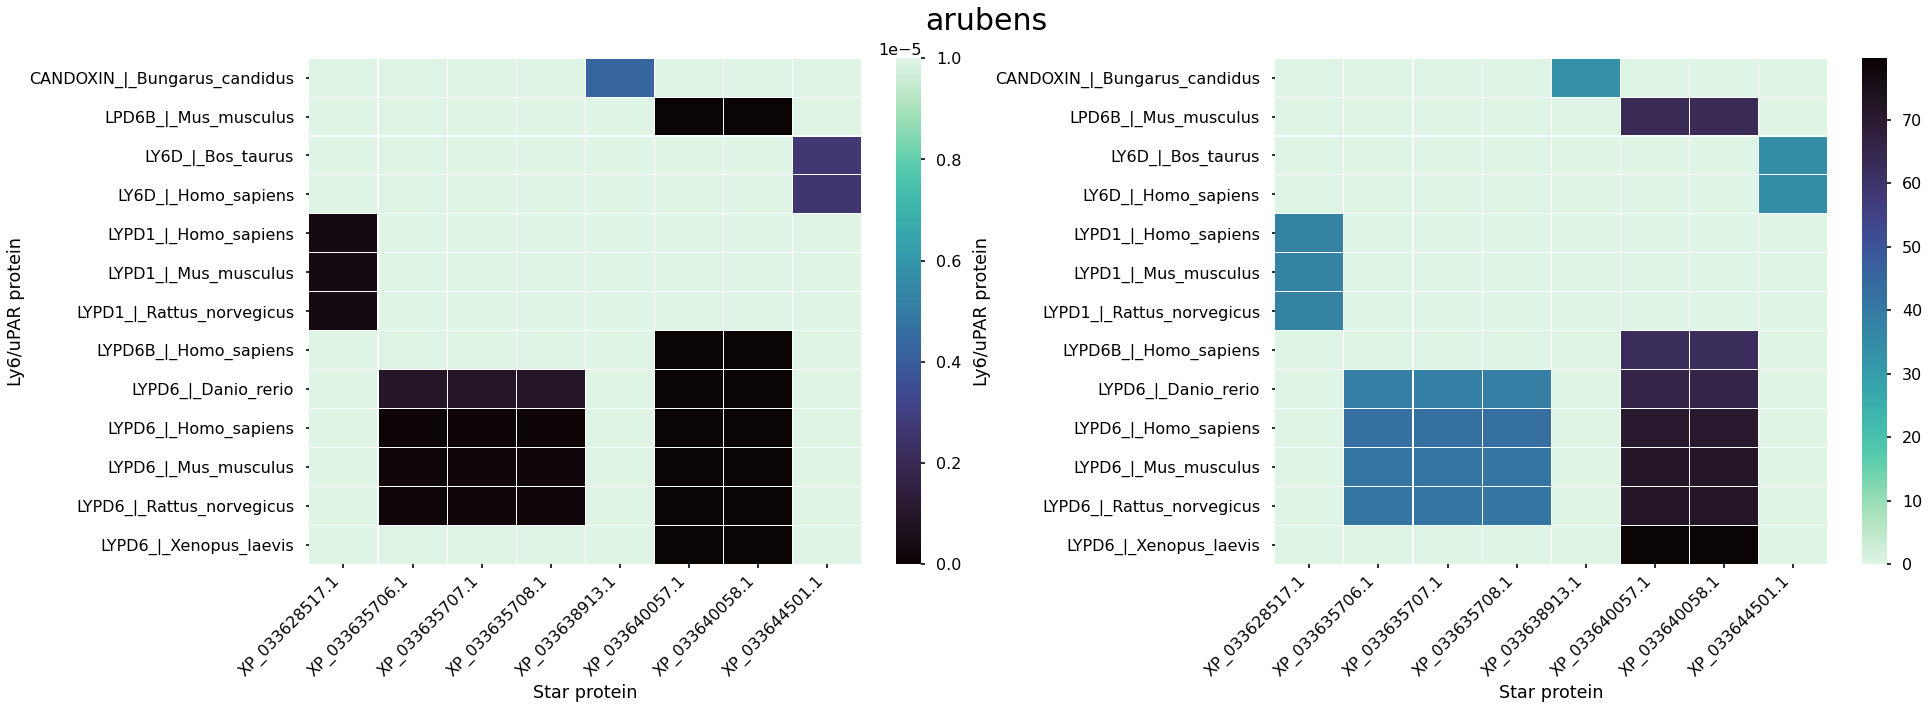

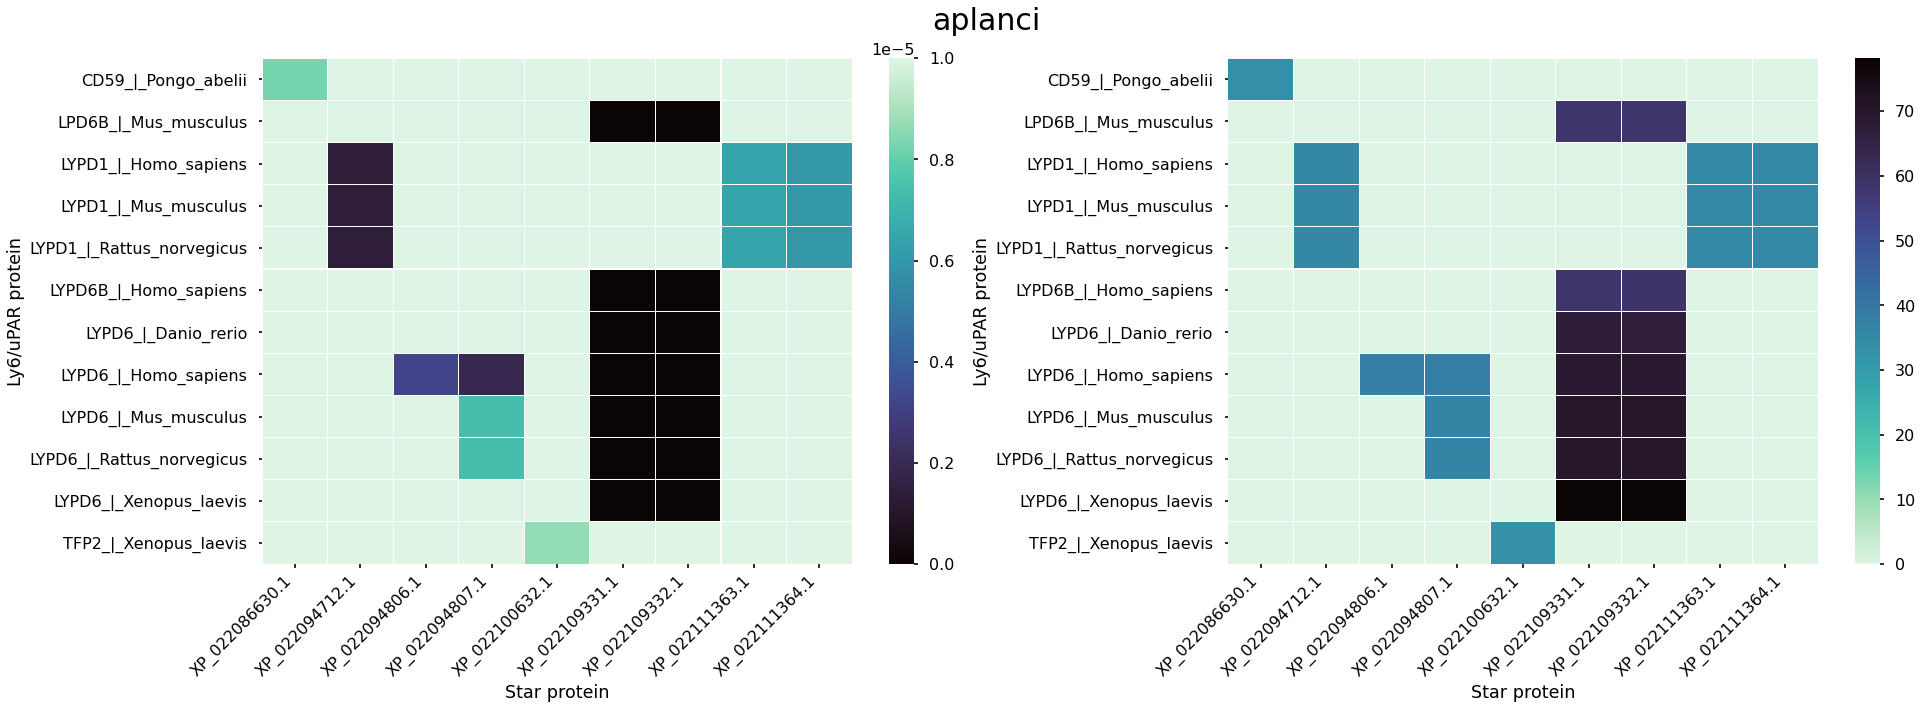

In [26]:
def print_heatmap(path):
    sp = 'Star protein'
    lp = 'Ly6/uPAR protein'
    ev = 'e-value'
    bs = 'bit score'
    df = pd.read_csv(path, sep='\t', header=None).rename(columns={
        0: sp,
        1: lp,
        10: ev,
        11: bs
    })
    kwargs = {'cmap': 'mako', 'linecolor': 'white', "linewidths": 0.1}
    fig, ax = plt.subplots(1, 2, figsize=(27.5, 10))
    sns.heatmap(data=df.pivot(index=lp, columns=sp, values=ev).fillna(1), ax=ax[0], vmax=1e-05, **kwargs)
    
    kwargs['cmap'] = kwargs['cmap'] + '_r'
    sns.heatmap(data=df.pivot(index=lp, columns=sp, values=bs).fillna(0), ax=ax[1], **kwargs)
    for i in ax:
        i.set_xticklabels(i.get_xticklabels(), rotation = 45, ha="right", va='center_baseline')
    fig.suptitle(os.path.split(path)[-1].split('_')[0], fontsize=30)
    plt.tight_layout()
    plt.savefig(f"result/img/{path.split('/')[-1].rsplit('.', 1)[0]}.svg", format='svg')
    plt.show()
print_heatmap('blast/arubens_blast_short.txt')
print_heatmap('blast/aplanci_blast_short.txt')

In [27]:
def similarity(x: str, y: str, d: dict):
    res = [1 for i, j in enumerate(x) if d[j] == d[y[i]]]
    return f'{round(sum(res) * 100 / len(x), 1)}%'

In [28]:
def get_aln(gene: str, org: str,star_blast: pd.DataFrame, df: pd.DataFrame):
    seq = pd.DataFrame(star_blast.loc[gene.replace(' ', '_') + '_|_' + org.replace(' ', '_')]).T
    ly6upar_ser = short.set_index('id').loc[df.loc[gene, 'hit ly6 protein']]
    if isinstance(ly6upar_ser, pd.Series):
        ly6upar_ser = pd.DataFrame(ly6upar_ser).T
    return pd.concat([ly6upar_ser, seq]).fillna('').reset_index().rename(columns={'index': 'id'})

In [29]:
color_map = """-=#ffffff
A=#7eff00
C=#ffe300
D=#ff0000
E=#ff0000
F=#7eff00
G=#ff00e4
H=#7eff00
I=#7eff00
K=#007bff
L=#7eff00
M=#7eff00
N=#ff00e4
P=#7eff00
Q=#ff00e4
R=#7eff00
S=#ff00e4
T=#ff00e4
V=#7eff00
W=#7eff00
X=#7eff00
Y=#ff00e4""".split('\n')
color_map = {i.split('=')[0]: i.split('=')[1] for i in color_map}
tmp = {}
for k, v in color_map.items():
    tmp[v] = tmp.get(v, []) + [k]
d = {a: res for (_, v), res in zip(tmp.items(), range(len(tmp))) for a in v}    

In [30]:
def get_genes_for_point_aln(star_name, organism):
    star_blast = read_blast(f'{star_name}_seq.csv', organism)
    df = pd.read_csv(f'blast/{star_name}_blast_short.txt', sep='\t', header=None)
    cols = [
        'star gene',
        'hit ly6 protein',
        'ident percent',
        'alignment length',
        'mismatch',
        'gapopen',
        'alignment start aa from star protein',
        'alignment end aa from star protein',
        'alignment start aa from ly6 protein',
        'alignment end aa from ly6 protein',
        'blast e-value',
        'blast bit score',
    ]
    df.columns = cols
    df = df.set_index(cols[0])
    return star_blast, df

In [31]:
def get_combs_of_loops(loops):
    try:
        combs = [
            (loops[1], loops[2]),
            (loops[0], loops[4]),
            (loops[3], loops[5]),
            (loops[6], loops[9]),
            (loops[7], loops[8]),
            (loops[10], loops[11]),
        ]
    except IndexError:
        try:
            combs = [
                (loops[1], loops[2]),
                (loops[0], loops[4]),
                (loops[3], loops[5]),
                (loops[6], loops[7]),
                0,
                (loops[8], loops[9]),
            ]
        except IndexError:
            combs = [
                (loops[1], loops[3]),
                (loops[0], loops[2]),
                0,
                (loops[4], loops[5]),
                0,
                (loops[6], loops[7]),
                
            ]
    return combs

In [32]:
def print_loops(loops, ax, pos=-0.1, color='r'):
    if pos > 0:
        j = pos + 1.4
        st = j + 1
        add_v = -1
    else:
        j = -1.4
        st = j - 1
        add_v = 1
    loops_c = Counter(loops)

    if np.unique(list(loops_c.values())).shape[0] == 1:
        loops = sorted(set(loops))
        combs = get_combs_of_loops(loops)

        for i in combs:
            if i:
                ax.plot(i, [j, j], color=color)
                ax.plot([i[0]] * 2, [pos, j], color=color)
                ax.plot([i[1]] * 2, [pos, j], color=color)

            if pos > 0:
                j += -add_v if j < st else add_v
            else:
                j += -add_v if j > st else add_v
    else:
        return 1

In [34]:
def get_pictures(star_blast, df, organism):
    
    star_genes = df.index.unique().tolist()
    
    for gene in star_genes:
        try:
            tmp = get_aln(gene, org=organism, star_blast=star_blast, df=df)
        except KeyError:
            print(gene, 'protein has duplicated domain')
            continue
        print_aln_lystar(gene, organism, tmp)


def print_aln_lystar(gene, organism, tmp):
    gene = gene.split('_|_')[0]
    sequence_dict = {k: ProteinSequence(v) for k, v in tmp.set_index('id').domain.to_dict().items()}

    headers = list(sequence_dict.keys())
    sequences = list(sequence_dict.values())

    # Perform a multiple sequence alignment
    matrix = pd.read_csv('matrix.txt', sep='\s+', skiprows=1, index_col=0)
    matrix = matrix.melt(ignore_index=False)

    alph1 = sequences[0].get_alphabet()
    alph2 = sequences[0].get_alphabet()
    matrix_dict = matrix.set_index('variable', append=True).value.to_dict()

    matrix = SubstitutionMatrix(alph1, alph2, matrix_dict)

    alignment, order, _, _ = align_multiple(sequences, matrix)

    # Order alignment according to guide tree
    alignment = alignment[:, order.tolist()]
    aln_seqs = alignment.get_gapped_sequences()

    ref_seq = aln_seqs[0]
    headers = [headers[i].replace('_', ' ') for i in order]
    headers = [name for i, name in enumerate(headers)]
    #   + '    ' + similarity(ref_seq, aln_seqs[i], d)
    ref_head = headers[0]

#         for k, v in zip(headers, aln_seqs):
#             print(k, ':', similarity(ref_seq, v, d))
    fig, ax = plt.subplots(1, 1, figsize=(
        len(max(sequences, key=len)) / 3, 4))

    loops = plot_alignment_type_based(
        ax, alignment, labels=headers,
        symbols_per_line=len(alignment),
        label_size=15, symbol_size=12, number_size=15,
        show_similarity={'func': similarity, 'dict': d, 'label': 'Similarity'},
        color_scheme=list(map(color_map.get, sequences[0].get_alphabet()))
    )
    adj = 0.6
    color = 'orange'
    print_loops(loops[0], ax, -adj, color)

    if loops[0] != loops[1]:
        print_loops(loops[1], ax, len(sequences) + adj, color)

    ax.set_aspect('equal', share=True)

#         red_patch = mpatches.Patch(color='red', label='Lystar loops')
#         blue_patch = mpatches.Patch(color='blue', label='Ly6/uPAR loops')
#         ax.legend(handles=[red_patch, blue_patch], loc='upper left', title='Loops colors', title_fontsize='xx-large')

    plt.tight_layout()
    fig.savefig(f'result/img/a{organism.split(" ")[1]}_{gene}_alignment.svg')
    plt.show()


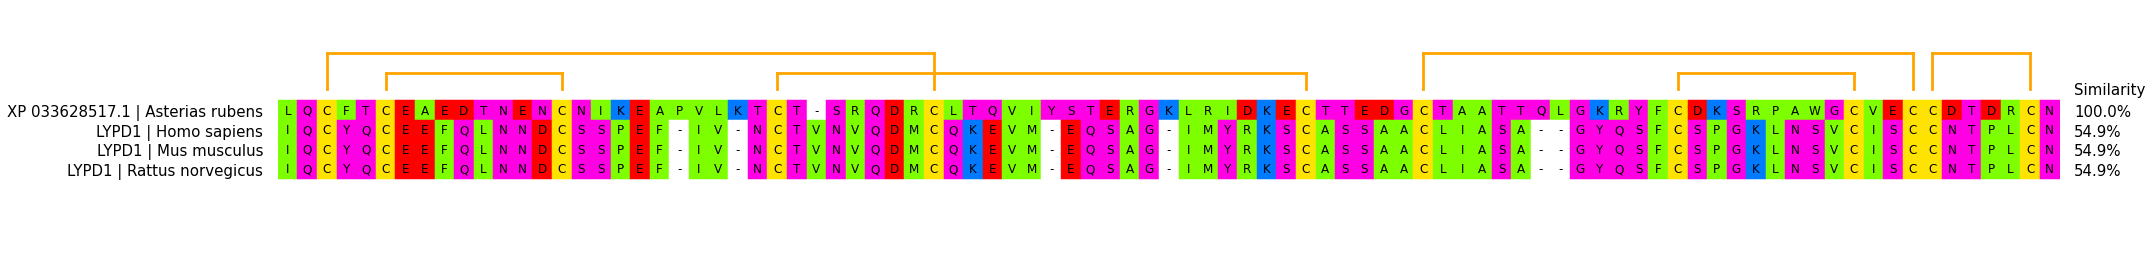

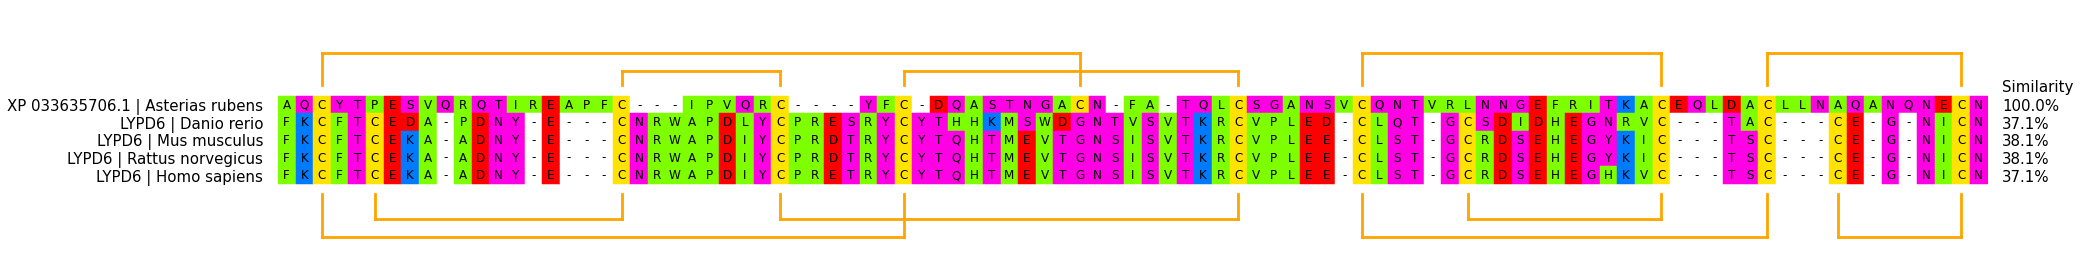

XP_033635707.1 protein has duplicated domain
XP_033635708.1 protein has duplicated domain


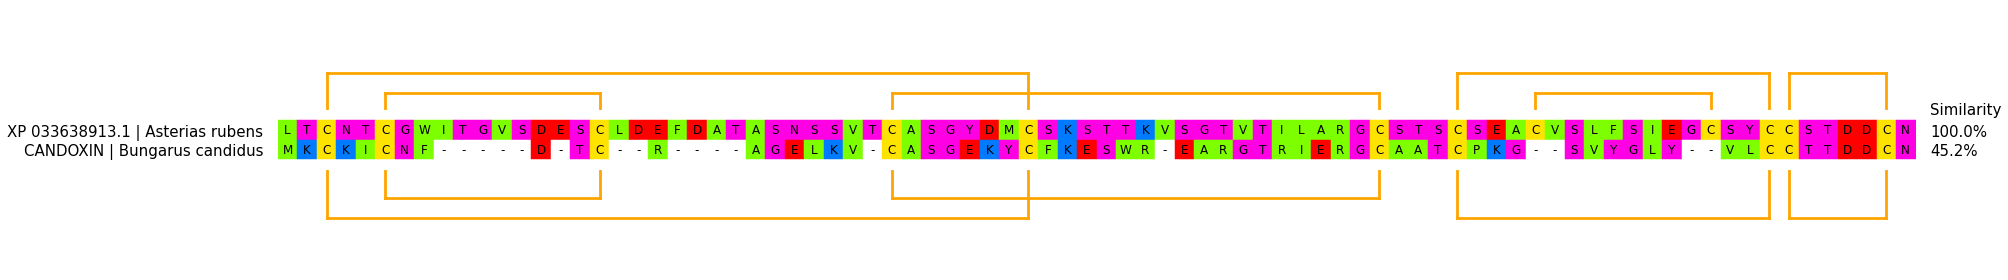

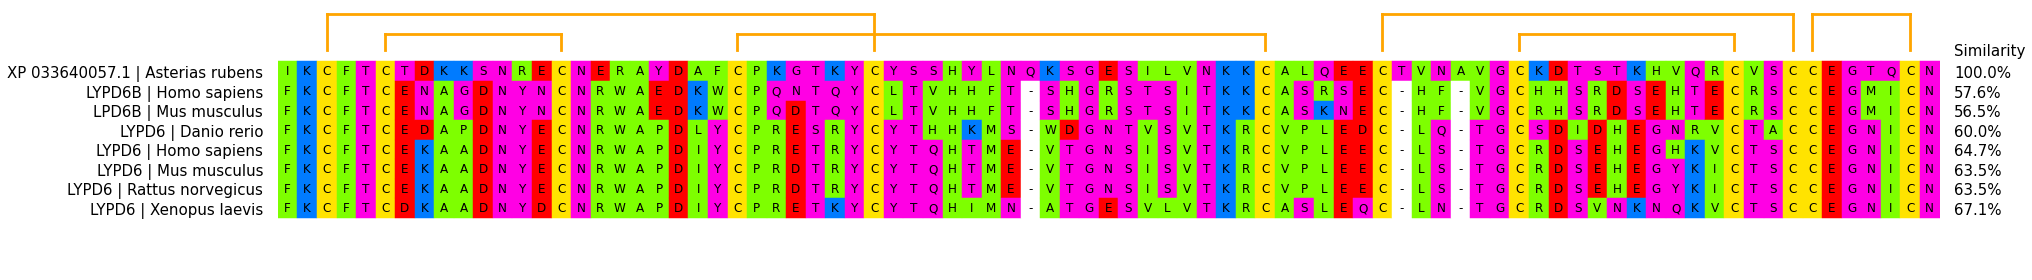

XP_033640058.1 protein has duplicated domain


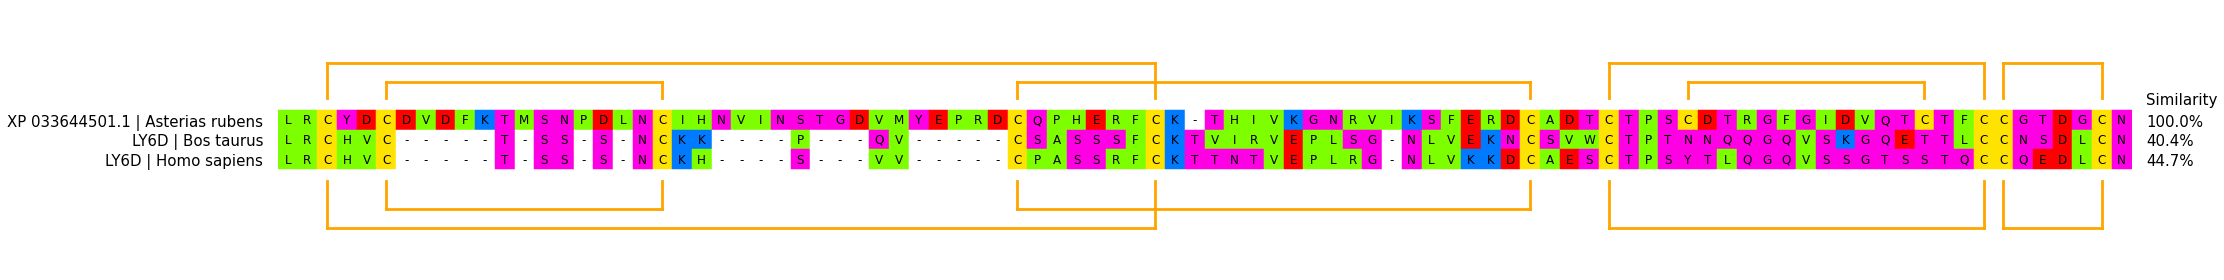

In [35]:
star_blast, df = get_genes_for_point_aln('arubens', 'Asterias rubens')
get_pictures(star_blast, df, 'Asterias rubens',)

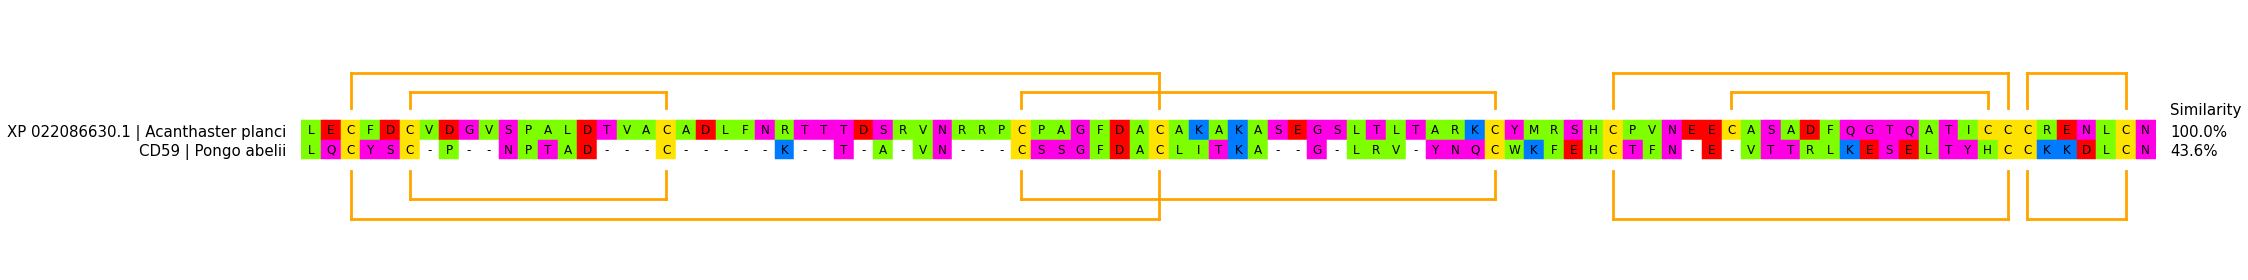

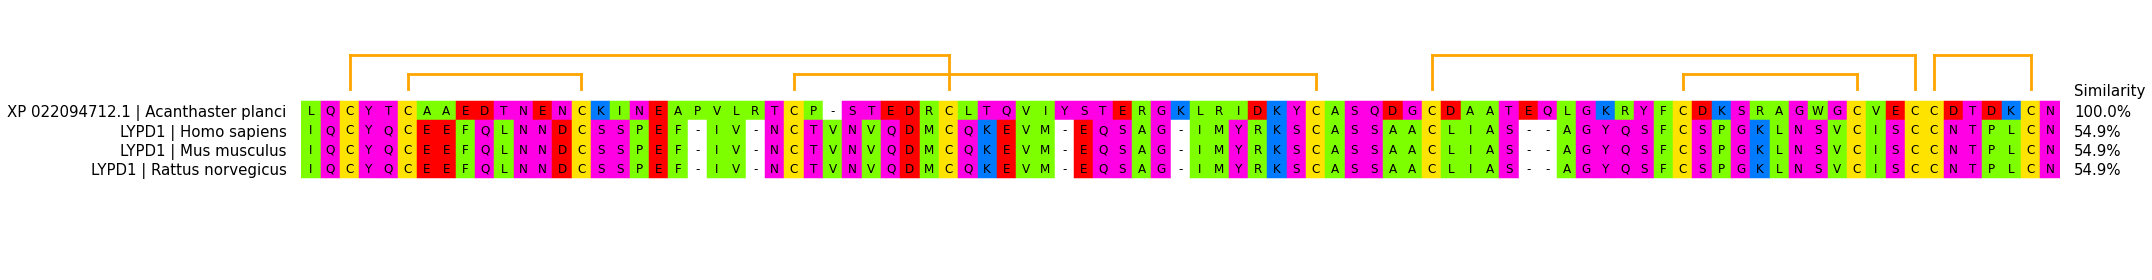

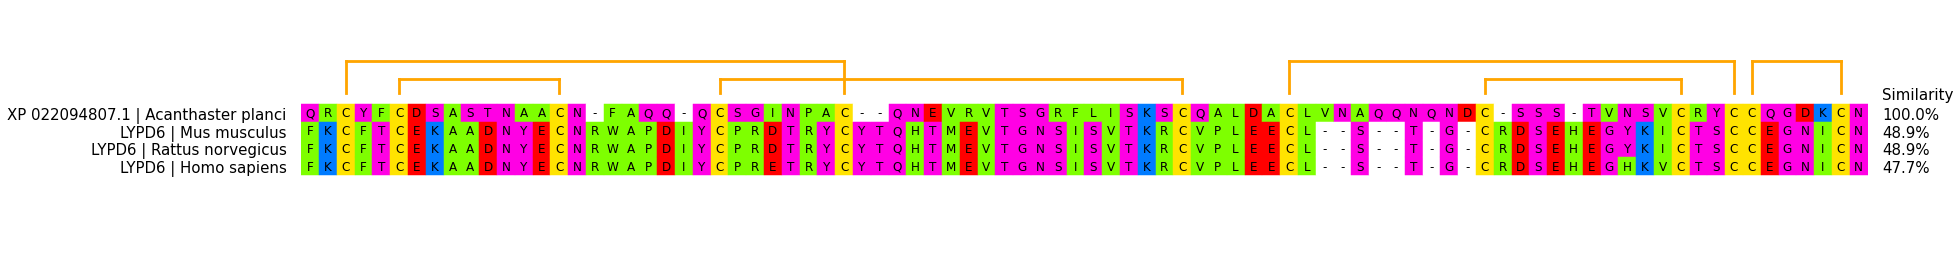

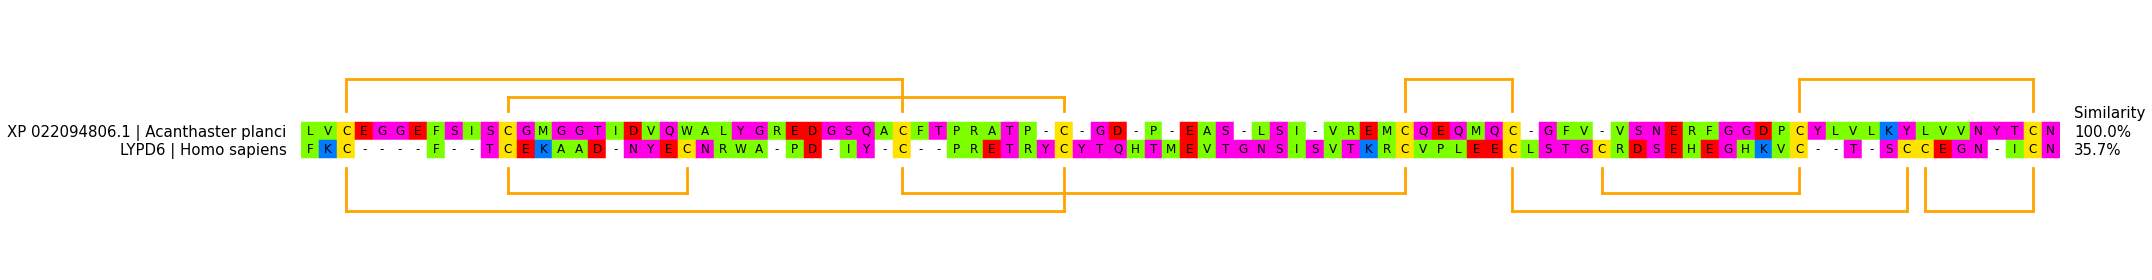

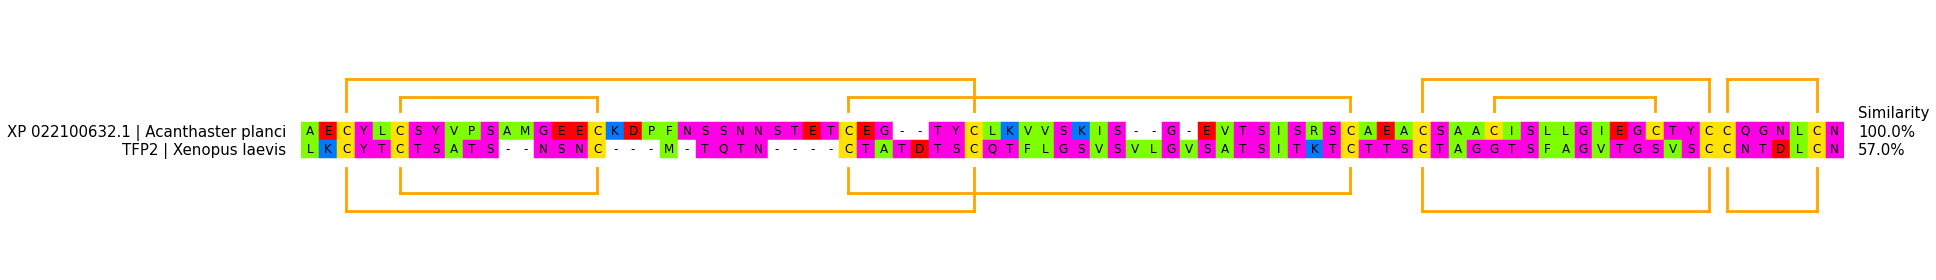

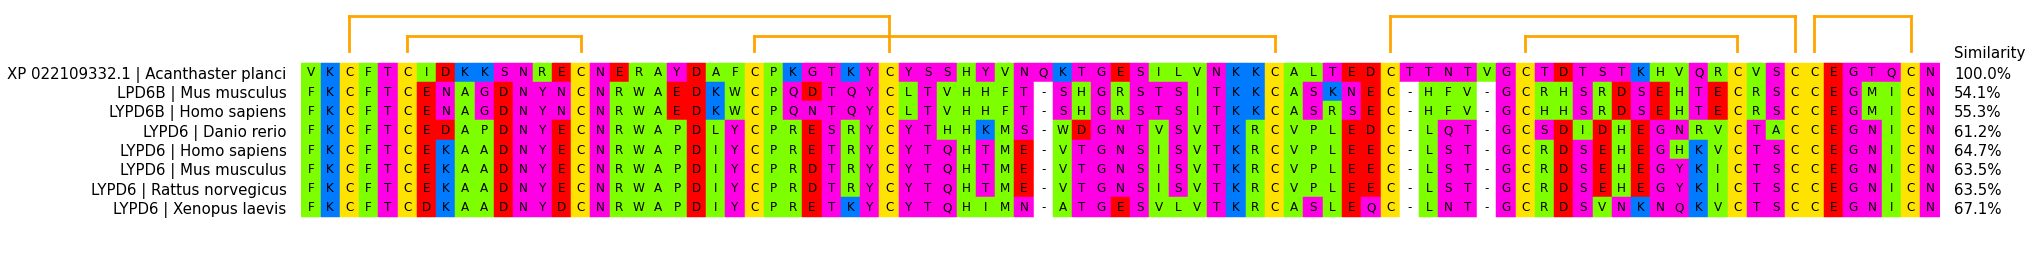

XP_022109331.1 protein has duplicated domain


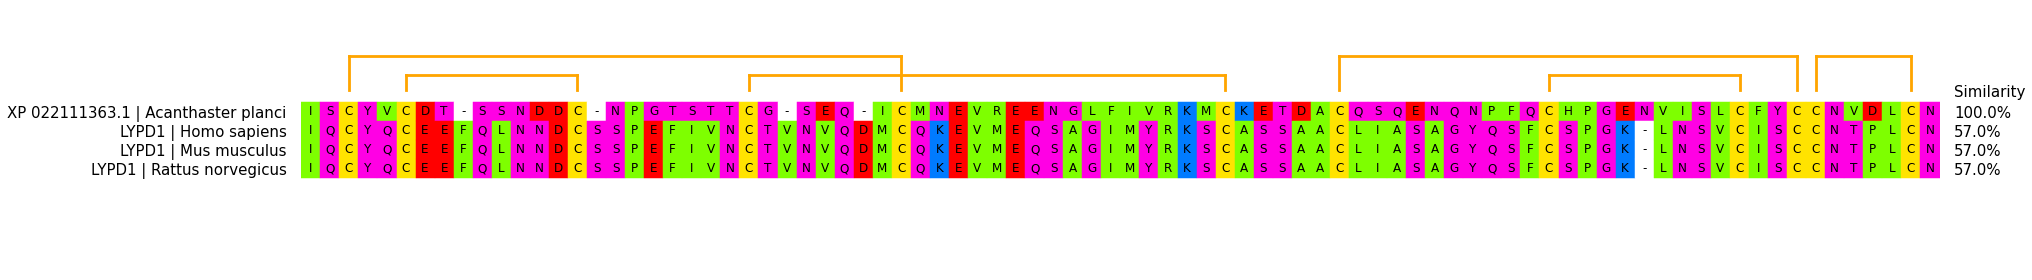

XP_022111364.1 protein has duplicated domain


In [36]:
star_blast, df = get_genes_for_point_aln('aplanci', 'Acanthaster planci')
get_pictures(star_blast, df, 'Acanthaster planci')

In [37]:
mapper_color_itol = {
    'Amphibia': '\trange\t#e7ffac\tAmphibia\n',
    'Actinopterygii': '\trange\t#c4faf8\tActinopterygii\n',
#     'Cytotoxins': '\trange\t#b5b9ff\tCytotoxins\n',
#     'MT family': '\trange\t#ffb5e8\tMT family\n',
    'Mammalia': '\trange\t#fbe4ff\tMammalia\n',
    'Toxins': '\trange\t#fff5ba\tToxins\n',
    'Insecta': '\trange\t#cfe2f3\tInsecta\n',
    'Lystar proteins' : '\trange\t#ff4b4b\tLystar proteins\n',
#     'Fasciculins': '\trange\t#dcd3ff\tFasciculins\n',
    'Aves': '\trange\t#ffcbc1\tAves\n',
    'Parasites': '\trange\t#ffffff\tParasite of humans\n'
}

In [38]:
mapper_tax_itol = {
    'Schistosoma mansoni': 'Parasites',
    'Homo sapiens': 'Mammalia',
    'Dendroaspis angusticeps': 'Toxins',
    'Aneides lugubris': 'Amphibia',
    'Macaca mulatta': 'Mammalia',
    'Naja oxiana': 'Toxins',
    'Rattus norvegicus': 'Mammalia',
    'Naja kaouthia': 'Toxins',
    'Laticauda semifasciata': 'Toxins',
    'Danio rerio': 'Actinopterygii',
    'Oryctolagus cuniculus': 'Mammalia',
    'Sus scrofa': 'Mammalia',
    'Mus musculus': 'Mammalia',
    'Dendroaspis polylepis polylepis': 'Toxins',
    'Bos taurus': 'Mammalia',
    'Gallus gallus': 'Aves',
    'Saimiri sciureus': 'Mammalia',
    'Xenopus laevis': 'Amphibia',
    'Micrurus altirostris': 'Toxins',
    'Bungarus candidus': 'Toxins',
    'Laticauda colubrina': 'Toxins',
    'Lithobates sylvaticus': 'Amphibia',
    'Callithrix sp.': 'Mammalia',
    'Dendroaspis jamesoni kaimosae': 'Toxins',
    'Aotus trivirgatus': 'Mammalia',
    'Papio sp.': 'Mammalia',
    'Canis lupus familiaris': 'Mammalia',
    'Naja atra': 'Toxins',
    'Saimiriine herpesvirus 2 (strain 11)': 'Parasites',
    'Micrurus mipartitus': 'Toxins',
    'Saimiri boliviensis boliviensis': 'Mammalia',
    'Macaca fascicularis': 'Mammalia',
    'Batrachuperus londongensis': 'Amphibia',
    'Boiga irregularis': 'Toxins',
    'Pan troglodytes': 'Mammalia',
    'Notophthalmus viridescens': 'Amphibia',
    'Oryzias latipes': 'Actinopterygii',
    'Drosophila melanogaster': 'Insecta',
    'Cynops orientalis': 'Amphibia',
    'Bungarus multicinctus': 'Toxins',
    'Chlorocebus aethiops': 'Mammalia',
    'Nilaparvata lugens': 'Insecta',
    'Ophiophagus hannah': 'Toxins',
    'Boiga dendrophila': 'Toxins',
    'Pongo abelii': 'Mammalia',
    'Naja pallida': 'Toxins',
    'Plethodon shermani': 'Amphibia',
    'Meleagris gallopavo': 'Aves',
    'Schistosoma mansoni': 'Parasites',
    'Asterias rubens': 'Lystar proteins',
    'Acanthaster planci': 'Lystar proteins',
    
}
set(short.org.unique()) - set(mapper_tax_itol), set(mapper_tax_itol) - set(short.org.unique())

(set(), {'Acanthaster planci', 'Asterias rubens'})

In [39]:
labels = [i.split('\t')[2].strip() for i in mapper_color_itol.values()]
colors = [i.split('\t')[3].strip() for i in mapper_color_itol.values()]

In [40]:
with open('result/range_colors_arubens.txt', 'w') as f:
    f.write('TREE_COLORS\nSEPARATOR TAB\n')
    f.write('LEGEND_TITLE\tAnnotation\n')
    f.write('LEGEND_COLORS\t' + '\t'.join(colors) + '\n')
    f.write('LEGEND_LABELS\t' + '\t'.join(labels) + '\n')
    f.write('DATA\n')
    for i, j in short.iterrows():
        if 'strain 11' in j.org:
            continue
        f.write(j.id + mapper_color_itol[mapper_tax_itol.get(j.org)])
    for i, j in aru.iterrows():
        f.write(i + mapper_color_itol[mapper_tax_itol.get(j.org)])

In [41]:
with open('result/range_colors_aplanci.txt', 'w') as f:
    f.write('TREE_COLORS\nSEPARATOR TAB\n')
    f.write('LEGEND_TITLE\tAnnotation\n')
    f.write('LEGEND_COLORS\t' + '\t'.join(colors) + '\n')
    f.write('LEGEND_LABELS\t' + '\t'.join(labels) + '\n')
    f.write('DATA\n')
    for i, j in short.iterrows():
        if 'strain 11' in j.org:
            continue
        f.write(j.id + mapper_color_itol[mapper_tax_itol.get(j.org)])
    for i, j in apl.iterrows():
        f.write(i + mapper_color_itol[mapper_tax_itol.get(j.org)])